# Graphs
> Comparing embeddings for Polblogs

Here we will compare 3 embedding methods:
1. Poincare embeddings:
    * This is an implementation of Nickel and Kiela's method from [Poincaré Embeddings for Learning Hierarchical Representations](https://arxiv.org/abs/1705.08039)
    * Can simply use `geomstats.datasets.prepare_graph_data.HyperbolicEmbedding`
2. Mixed-curvature embeddings:
    * This is taken from [Learning Mixed-Curvature Representations in Product Spaces](https://openreview.net/forum?id=HJxeWnCcF7)
    * Adapted code from [this Github repo](https://github.com/HazyResearch/hyperbolics)
3. Combinatorial algorithm:
    * This is taken from [Representation Tradeoffs for Hyperbolic Embeddings](https://arxiv.org/abs/1804.03329)
    * Adapted code from same repo as (2)

Not currently being explored:
* [Learning Continuous Hierarchies in the Lorentz Model of Hyperbolic Geometry](https://arxiv.org/abs/1806.03417)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from tqdm import tqdm_notebook as tqdm

from pickle import dump, load

# import geomstats
from geomstats.datasets.prepare_graph_data import Graph, HyperbolicEmbedding
from geomstats.geometry.hyperbolic import Hyperbolic

# deepcopy
from copy import deepcopy

from scipy.spatial.distance import pdist, squareform

# Repo: https://github.com/HazyResearch/hyperbolics
from hyperbolics.utils.distortions import map_score, distortion

# from hyperbolics.pytorch.pytorch_hyperbolic import learn
# from hyperbolics.utils import load_graph

# Repo: https://github.com/amoretti86/hyperbolic_embeddings
from hyperbolic_embeddings.tools import embed as mixed_curvature_embed

from src.hyperdt.conversions import convert

# Benchmarking imports
from sklearn.model_selection import KFold
from src.hyperdt.tree import DecisionTreeClassifier, HyperbolicDecisionTreeClassifier
from src.hyperdt.forest import HyperbolicRandomForestClassifier
from src.hyperdt.visualization import plot_tree

INFO: Using numpy backend


In [3]:
EPOCHS = 20
LOAD = True

## Load graphs

This assumes we are using the netset convention. In particular, it assumes that a 
directory contains the following files:
* `adjacency.tsv`: TSV with columns "start_node, end_node, weight"
* `labels.tsv`: TSV with column "label", ordered by node index
* `names.tsv` (optional): TSV with column "name", ordered by node index
* `names_labels.tsv` (optional): TSV with column "name", ordered by label index

In [5]:
def load_graph(graph_dir, graph_type="directed", edge_type="unweighted", add_isolates=False, top_cc=False):
    # Specify paths
    adjacency_path = f"{graph_dir}/adjacency.tsv"
    dense_adjacency_path = f"{graph_dir.replace('/raw/', '/interim/')}/adjacency_dense.tsv"
    labels_path = f"{graph_dir}/labels.tsv"
    label_names_path = f"{graph_dir}/names_labels.tsv"
    names_path = f"{graph_dir}/names.tsv"

    # Adjacency matrix: (out_node, in_node)
    adjacency = pd.read_table(adjacency_path, header=None, usecols=[0, 1])

    # Labels: (label, )
    labels = pd.read_table(labels_path, header=None, usecols=[0])[0]

    # Label name: (label_name, )
    if os.path.exists(label_names_path):
        label_names = pd.read_table(label_names_path, header=None, usecols=[0])[0]
    else:
        label_names = pd.Series(labels[0].unique()).reset_index()

    # Node name: (node_name, )
    if os.path.exists(names_path):
        names = pd.read_table(names_path, header=None, usecols=[0])[0]
    else:
        names = pd.Series(np.arange(len(labels))).reset_index()

    # Networkx object
    base_graph = nx.DiGraph if graph_type == "directed" else nx.Graph
    networkx_graph = nx.from_pandas_edgelist(adjacency, source=0, target=1, create_using=base_graph)
    if add_isolates:
        networkx_graph.add_nodes_from(names.index)

    # Add names and labels to nodes
    nx.set_node_attributes(networkx_graph, dict(zip(names.index, labels)), "label")
    networkx_graph = nx.relabel_nodes(networkx_graph, dict(zip(names.index, names)))

    # Get connected components
    if top_cc:
        networkx_graph = networkx_graph.subgraph(max(nx.connected_components(networkx_graph), key=len))

    # Pairwise distances
    distances = nx.floyd_warshall_numpy(networkx_graph)

    # Geomstats object
    dense_adjacency = nx.to_numpy_array(networkx_graph)
    np.savetxt(dense_adjacency_path, dense_adjacency, fmt="%d", delimiter="\t")
    geomstats_graph = Graph(graph_matrix_path=dense_adjacency_path, labels_path=labels_path)

    return {
        "labels": list(networkx_graph.nodes(data="label")),
        "label_names": list(label_names),
        "names": list(networkx_graph.nodes()),
        "networkx_graph": networkx_graph,
        "geomstats_graph": geomstats_graph,
        "distances": distances,
    }


# polblogs = load_graph("data/raw/polblogs", graph_type="undirected", top_cc=True)
polblogs = load_graph("data/raw/polblogs", graph_type="directed", top_cc=False)

In [5]:
# Sanity check sizes:

for k, v in polblogs.items():
    if hasattr(v, "shape"):
        print(k, v.shape)
    elif hasattr(v, "__len__"):
        print(k, len(v))
    else:
        print(k, v.n_nodes)

labels 1224
label_names 2
names 1224
networkx_graph 1224
geomstats_graph 1224
distances (1224, 1224)


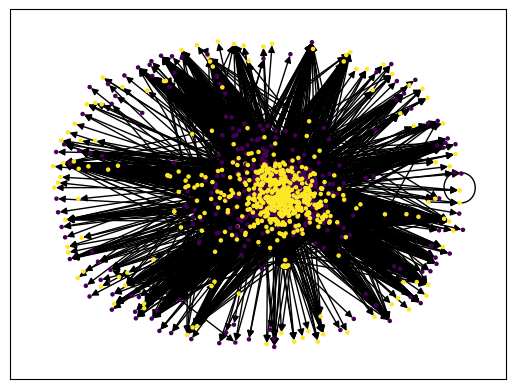

In [6]:
# Some basic plotting

nx.draw_networkx(
    polblogs["networkx_graph"],
    with_labels=False,
    node_size=5,
    node_color=[x[1] for x in polblogs["labels"]],
)

## Distortion and Mean average precision

**Mean average precision:** Let some node $a \in V$ have neighborhood $\mathcal{N}_a = \{b_1, b_2, \ldots, b_{deg(a)} \}$
where $a$ denotes the degree of $a$. Then we let $R_{a, b_i}$ mean the smallest set of nearest points required to retrieve the $i$-th neighbor of $a$ in our embedding space $f$. MAP is:
$$
\begin{align*}
MAP(f) &= \frac{1}{|V|} \sum_{a \in V} \frac{1}{|\mathcal{N}_a|} \sum_{i=1}^{|\mathcal{N}_a|} Precision(R_{a,b_i})\\
&= \frac{1}{|V|} \sum_{a \in V} \frac{1}{deg(a)} \sum_{i=1}^{|\mathcal{N}_a|} \frac{|\mathcal{N}_a \cap R_{a, b_i}|}{|R_{a,b_i}|}
\end{align*}
$$
Best case: $MAP(f) = 1$; not concerned with the underlying distances, only neighborhood membership.

**Distortion:** For an $n$ point embedding, the distortion is
$$
D(f) = \frac{1}{n \choose 2}\left( \frac{|d_V(f(u), f(v)) - d_U(u,v)|}{d_U(u,v)} \right)
$$

**Worst-case distortion**
$$
\begin{align}
D &= \left\{ \frac{d_V(f(u), f(v))}{d_U(u,v)} : u, v \in U, u \neq v \right\}\\
D_{wc}(f) &= \frac{\max(D)}{\min(D)}
\end{align}
$$

## Poincare embeddings (geomstats implementation)

First, we will ensure we can learn an embedding for polblogs using geomstats

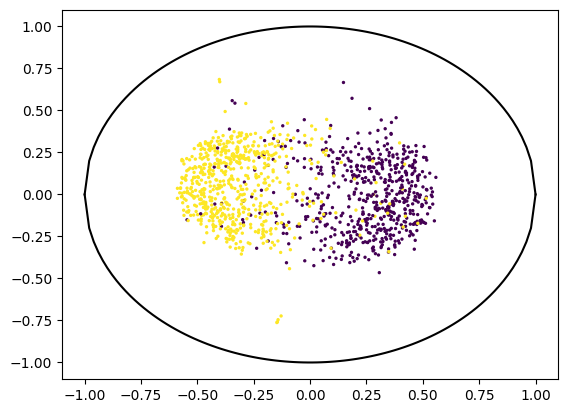

In [ ]:
# Embed - geomstats
if load:
    with open("data/processed/geomstats_embeddings.pkl", "rb") as f:
        geomstats_embeddings = load(f)
        polblogs_gs_embed = geomstats_embeddings["polblogs"]
else:
    print(f"Number of nodes: {polblogs['geomstats_graph'].n_nodes}")
    hyp_emb = HyperbolicEmbedding(dim=2, n_negative=10, n_context=10, lr=1e-2, max_epochs=EPOCHS)
    polblogs_gs_embed = hyp_emb.embed(polblogs["geomstats_graph"])
    print(f"Embedding shape: {polblogs_gs_embed.shape}")

# Plot embeddings
plt.scatter(
    polblogs_gs_embed[:, 0],
    polblogs_gs_embed[:, 1],
    c=[x[1] for x in polblogs["labels"]],
    s=2,
)

# Plot poincare disk
_x = np.linspace(-1, 1, 100)
_y = np.sqrt(1 - _x**2)
plt.plot(_x, _y, c="black")
plt.plot(_x, -_y, c="black")
plt.show()

In [ ]:
# Assess distortion


def assess_embedding(embedding, true_dists=polblogs["distances"], dim=2, coords="ball"):
    # Clip to max distance in embeddings
    manifold = Hyperbolic(dim, default_coords_type=coords)
    pairwise_dists = squareform(pdist(embedding, metric=manifold.metric.dist))
    graph_dists = np.clip(true_dists, a_min=None, a_max=np.max(pairwise_dists))

    # Assess distortion:
    polblogs_gs_distortion = distortion(graph_dists, pairwise_dists, n=len(graph_dists), jobs=-1)
    polblogs_gs_map_score = map_score(graph_dists, pairwise_dists, n=len(graph_dists), jobs=-1)
    return polblogs_gs_distortion, polblogs_gs_map_score


if load:
    polblogs_gs_distortion, polblogs_gs_map_score = (
        geomstats_embeddings["polblogs_distortion"],
        geomstats_embeddings["polblogs_map_score"],
    )
else:
    polblogs_gs_distortion, polblogs_gs_map_score = assess_embedding(polblogs_gs_embed)

print(f"Distortion: {polblogs_gs_distortion[2]}")
print(f"MAP score: {polblogs_gs_map_score}")

Distortion: 0.5844391685778756
MAP score: 0.07095810377684776


In [ ]:
# Dump embeddings - this frees up RAM for the next step

if not load:
    geomstats_embeddings = {
        "polblogs": polblogs_gs_embed,
        "polblogs_distortion": polblogs_gs_distortion,
        "polblogs_map_score": polblogs_gs_map_score,
    }

    with open("data/processed/geomstats_embeddings.pkl", "wb") as f:
        dump(geomstats_embeddings, f)

    del polblogs_gs_embed
    del polblogs_gs_distortion
    del polblogs_gs_map_score
    del geomstats_embeddings

## Mixed-curvature embeddings (Antonio's version)

def embed(G, types_list, dims_list, n_iters=200, lr=0.001):
* G: an adjacency matrix (list of lists)
* types_list: a list of manifold types (h, s, e)
* dims_list: a list of manifold dimensions

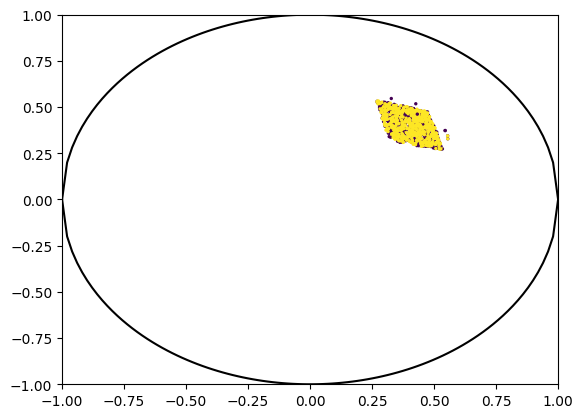

In [ ]:
# 100: 1.4s
# 200: 6.1s (4.3x)
# 400: 24.4s (4.0x)
# 800: 95.8s (3.9x)

if load:
    with open("data/processed/mixed_curvature_embeddings.pkl", "rb") as f:
        mixed_curvature_embeddings = load(f)
        polblogs_mc_embed = mixed_curvature_embeddings["polblogs"]
else:
    polblogs_mc_embed = mixed_curvature_embed(
        polblogs["distances"],
        types_list=["h"],
        dims_list=[2],
        lr=1e-6,
        n_iters=EPOCHS,
    )
    polblogs_mc_embed = np.array([x.detach().numpy() for x in polblogs_mc_embed[0]])

# Convert to Poincare disk for visualization
polblogs_mc_poincare = convert(polblogs_mc_embed, "hyperboloid", "poincare")

# Plot embeddings
plt.scatter(
    polblogs_mc_poincare[:, 0],
    polblogs_mc_poincare[:, 1],
    c=[x[1] for x in polblogs["labels"]],
    s=2,
)
_x = np.linspace(-1, 1, 100)
_y = np.sqrt(1 - _x**2)
plt.plot(_x, _y, c="black")
plt.plot(_x, -_y, c="black")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

In [ ]:
# Assess distortion
if load:
    polblogs_mc_distortion, polblogs_mc_map_score = (
        mixed_curvature_embeddings["polblogs_distortion"],
        mixed_curvature_embeddings["polblogs_map_score"],
    )
else:
    polblogs_mc_distortion, polblogs_mc_map_score = assess_embedding(polblogs_mc_embed, coords="extrinsic")

print(f"Distortion: {polblogs_mc_distortion[2]}")
print(f"MAP score: {polblogs_mc_map_score}")

Distortion: 0.7199662769085583
MAP score: 0.02638694475434763


In [ ]:
# Dump embeddings - this frees up RAM for the next step

if not load:
    mixed_curvature_embeddings = {
        "polblogs": polblogs_mc_embed,
        "polblogs_distortion": polblogs_mc_distortion,
        "polblogs_map_score": polblogs_mc_map_score,
    }

    with open("data/processed/mixed_curvature_embeddings.pkl", "wb") as f:
        dump(mixed_curvature_embeddings, f)

    del polblogs_mc_embed
    del polblogs_mc_embed_np
    del polblogs_mc_poincare
    del polblogs_mc_distortion
    del polblogs_mc_map_score

## Combinatorial embeddings

In [ ]:
def convert_adjacency_matrix(networkx_graph, out_path):
    # Renumber nodes 0-N
    networkx_graph = nx.convert_node_labels_to_integers(networkx_graph)

    # Save as tsv: (out_node, in_node)
    adjacency = pd.DataFrame(networkx_graph.edges())
    adjacency.to_csv(out_path, sep="\t", header=False, index=False)


if os.path.exists("data/interim/polblogs/combinatorial.edges"):
    print("Combinatorial edges already exist")
else:
    convert_adjacency_matrix(polblogs["networkx_graph"], "data/interim/polblogs/combinatorial.edges")

Combinatorial edges already exist


In [ ]:
%%bash

# /home/phil/mambaforge/envs/hdt/bin/julia hyperbolics/combinatorial/comb.jl -h

/home/phil/mambaforge/envs/hdt/bin/julia hyperbolics/combinatorial/comb.jl \
    -d /home/phil/hdt/data/interim/polblogs/combinatorial.edges \
    -m /home/phil/hdt/data/processed/combinatorial_embeddings.csv  \
    -e 0.001 \
    -r 2 \
    -p 256


Combinatorial Embedding. Info:
Data set = /home/phil/hdt/data/interim/polblogs/combinatorial.edges
Dimensions = 2
Precision = 256
Save embedding to /home/phil/hdt/data/processed/combinatorial_embeddings.csv
/home/phil/hdt/data/interim/polblogs/combinatorial.edges

Graph information
Number of vertices = 1222
Number of edges = 16717
Max degree = 351, Max path = 5

Performing the embedding
Epsilon  = 0.001
Scaling factor tau = 9996.81424089661
Using uniform sphere child placement
Placing children of node 100
Placing children of node 200
Placing children of node 300
Placing children of node 400
Placing children of node 500
Placing children of node 600
Placing children of node 700
Placing children of node 800
Placing children of node 900
Placing children of node 1000
Placing children of node 1100
Placing children of node 1200

Computing quality statistics


ERROR: LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/phil/mambaforge/envs/hdt/share/julia/packages/PyCall/ilqDX/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError("Buffer dtype mismatch, expected 'int' but got 'long'")
  File "_shortest_path.pyx", line 606, in scipy.sparse.csgraph._shortest_path.dijkstra

Stacktrace:
  [1] pyerr_check
    @ ~/mambaforge/envs/hdt/share/julia/packages/PyCall/ilqDX/src/exception.jl:75 [inlined]
  [2] pyerr_check
    @ ~/mambaforge/envs/hdt/share/julia/packages/PyCall/ilqDX/src/exception.jl:79 [inlined]
  [3] _handle_error(msg::String)
    @ PyCall ~/mambaforge/envs/hdt/share/julia/packages/PyCall/ilqDX/src/exception.jl:96
  [4] macro expansion
    @ ~/mambaforge/envs/hdt/share/julia/packages/PyCall/ilqDX/src/exception.jl:110 [inlined]
  [5] #107
    @ ~/mambaforge/envs/hdt/share/julia/packages/PyCall/ilqDX/src/pyfncall.jl:43 [inlined]
  [6] disable_sigint
    @ ./c.jl:47

CalledProcessError: Command 'b'\n# /home/phil/mambaforge/envs/hdt/bin/julia hyperbolics/combinatorial/comb.jl -h\n\n/home/phil/mambaforge/envs/hdt/bin/julia hyperbolics/combinatorial/comb.jl \\\n    -d /home/phil/hdt/data/interim/polblogs/combinatorial.edges \\\n    -m /home/phil/hdt/data/processed/combinatorial_embeddings.csv  \\\n    -e 0.001 \\\n    -r 2 \\\n    -p 256 \\\n    -s\n'' returned non-zero exit status 1.

Number of NaNs: 978


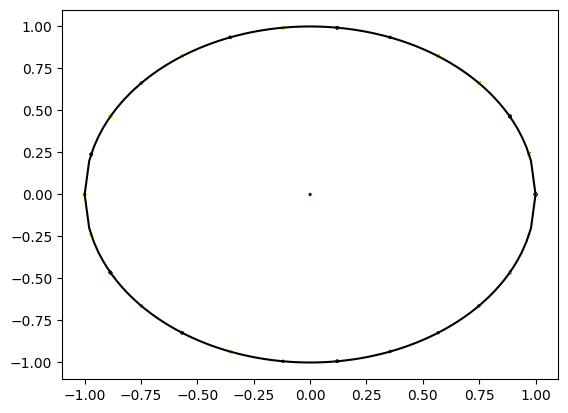

In [46]:
# Read embeddings

polblogs_comb_embedding = pd.read_csv("data/processed/combinatorial_embeddings.csv", usecols=[1, 2]).values
n_nans = np.isnan(polblogs_comb_embedding).sum()
print(f"Number of NaNs: {n_nans}")

# Plot embeddings
plt.scatter(
    polblogs_comb_embedding[:, 0],
    polblogs_comb_embedding[:, 1],
    c=[x[1] for x in polblogs["labels"]],
    s=2,
)
_x = np.linspace(-1, 1, 100)
_y = np.sqrt(1 - _x**2)
plt.plot(_x, _y, c="black")
plt.plot(_x, -_y, c="black")

In [48]:
# Assess distortion
# if load:
# polblogs_comb_distortion, polblogs_comb_map_score = (
#     combinatorial_embeddings["polblogs_distortion"],
#     combinatorial_embeddings["polblogs_map_score"],
# )
# else:
polblogs_comb_distortion, polblogs_comb_map_score = assess_embedding(polblogs_comb_embedding)

print(f"Distortion: {polblogs_comb_distortion[2]}")
print(f"MAP score: {polblogs_comb_map_score}")

AssertionError: 

# Classification benchmark

/tmp/ipykernel_21415/444846852.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  my_tqdm = tqdm(total=len(depths) * len(embeddings) * n_methods * n_splits)


  0%|          | 0/500 [00:00<?, ?it/s]

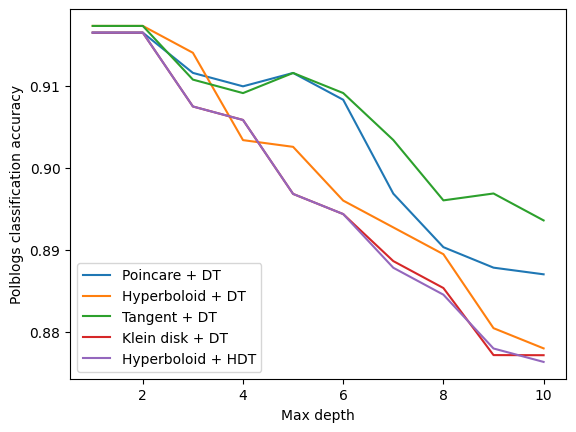

In [140]:
# This takes ~5 minutes at 10 splits, 5 methods, 10 depths

# Shared across all trials
manifold = Hyperbolic(2, default_coords_type="extrinsic")
y = np.array([x[1] for x in polblogs["labels"]])

# Arrays to iterate over
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
embeddings = [geomstats_embeddings]
n_methods = 5  # Simplest to just set this part manually
n_splits = 10

my_tqdm = tqdm(total=len(depths) * len(embeddings) * n_methods * n_splits)
cv = list(KFold(n_splits=10, shuffle=True).split(X))

# Collect results
results = []
for max_depth in depths:
    args = {"max_depth": max_depth}
    for embedding in embeddings:
        # Hyperboloid, Tangent@origin, Klein
        X = embedding["polblogs"]
        if X.shape[1] == 2:
            X_poincare, X = X, convert(X, "poincare", "hyperboloid")
        else:
            X_poincare = convert(X, "hyperboloid", "poincare")
        X_tangent = manifold.metric.log(X, base_point=np.array([1.0, 0.0, 0.0]))
        X_klein = convert(X, "hyperboloid", "klein")

        # Cross-vals:
        experiment = [
            (X_poincare, DecisionTreeClassifier, "Poincare + DT"),
            (X, DecisionTreeClassifier, "Hyperboloid + DT"),
            (X_tangent, DecisionTreeClassifier, "Tangent + DT"),
            (X_klein, DecisionTreeClassifier, "Klein disk + DT"),
            (X, HyperbolicDecisionTreeClassifier, "Hyperboloid + HDT"),
        ]
        for data, clf, name in experiment:
            clf = clf(**args)  # Init
            # scores = cross_val_score(clf, data, y, cv=5, verbose=1)
            scores = []
            my_tqdm.desc = f"{name} - {max_depth}"
            for train, test in cv:
                clf.fit(data[train], y[train])
                scores.append(clf.score(data[test], y[test]))
                my_tqdm.update(1)
            results.append({"Method": name, "Depth": max_depth, "Average": np.mean(scores), "Std": np.std(scores)})

results = pd.DataFrame(results)

# Plot: max depth vs. accuracy for each method
for method in results["Method"].unique():
    plt.plot(
        results[results["Method"] == method]["Depth"],
        results[results["Method"] == method]["Average"],
        label=method,
    )
plt.legend()
plt.xlabel("Max depth")
plt.ylabel("Polblogs classification accuracy")
plt.show()

Text(0, 0.5, 'Polblogs classification accuracy')

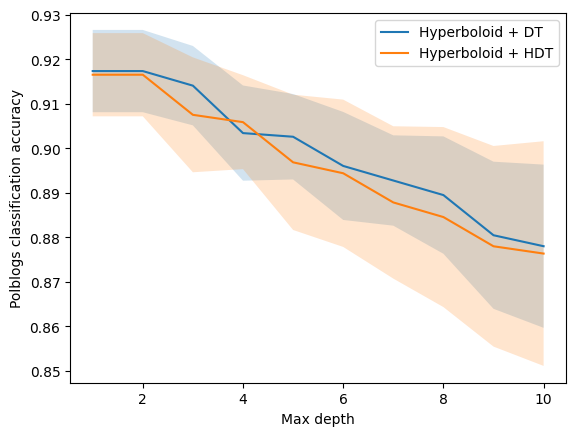

In [141]:
# Just the hyperboloid + DT vs. HDT methods, plus confidence intervals:

for method in ["Hyperboloid + DT", "Hyperboloid + HDT"]:
    plt.plot(
        results[results["Method"] == method]["Depth"],
        results[results["Method"] == method]["Average"],
        label=method,
    )
    conf_interval = 1.96 * results[results["Method"] == method]["Std"] / np.sqrt(10)
    plt.fill_between(
        results[results["Method"] == method]["Depth"],
        results[results["Method"] == method]["Average"] - conf_interval,
        results[results["Method"] == method]["Average"] + conf_interval,
        alpha=0.2,
    )

plt.legend()
plt.xlabel("Max depth")
plt.ylabel("Polblogs classification accuracy")

# Better (?) version of embeddings

In [1]:
!pip install hypll

  Obtaining dependency information for hypll from https://files.pythonhosted.org/packages/d4/fc/afa8fd0f950fc6ed92c8fbd540f3de2b248e672192c9f6f74da3e5358f68/hypll-0.1.0-py3-none-any.whl.metadata


In [7]:
from hypll.manifolds.poincare_ball import Curvature, PoincareBall

poincare_ball = PoincareBall(Curvature(1.0))

In [8]:
import random

import torch
from torch.utils.data import DataLoader, Dataset


class EmbeddingDataset(Dataset):
    def __init__(self, graph: nx.Graph, n_negative: int = 10, n_context: int = 10):
        super().__init__()
        # Rename nodes as integers
        graph = nx.convert_node_labels_to_integers(graph)

        self.graph = graph
        self.n_negative = n_negative
        self.n_context = n_context
        self.edges_list = list(graph.edges())

    # This Dataset object has a sample for each edge in the graph.
    def __len__(self) -> int:
        return len(self.edges_list)

    def __getitem__(self, idx: int):
        # For each existing edge in the graph we choose 10 fake or negative edges, which we build
        # from the idx-th existing edge. So, first we grab this edge from the graph.
        rel = self.edges_list[idx]

        # Next, we take our source node rel[0] and see which nodes in the graph are not a child of
        # this node.
        negative_target_nodes = list(self.graph.nodes() - nx.descendants(self.graph, rel[0]) - {rel[0]})

        # Then, we sample at most 5 of these negative target nodes...
        negative_target_sample_size = min(5, len(negative_target_nodes))
        negative_target_nodes_sample = random.sample(negative_target_nodes, negative_target_sample_size)

        # and add these to a tensor which will be used as input for our embedding model.
        edges = torch.tensor([rel] + [[rel[0], neg] for neg in negative_target_nodes_sample])

        # Next, we do the same with our target node rel[1], but now where we sample from nodes
        # which aren't a parent of it.
        negative_source_nodes = list(self.graph.nodes() - nx.ancestors(self.graph, rel[1]) - {rel[1]})

        # We sample from these negative source nodes until we have a total of 10 negative edges...
        negative_source_sample_size = 10 - negative_target_sample_size
        negative_source_nodes_sample = random.sample(negative_source_nodes, negative_source_sample_size)

        # and add these to the tensor that we created above.
        edges = torch.cat(
            tensors=(edges, torch.tensor([[neg, rel[1]] for neg in negative_source_nodes_sample])),
            dim=0,
        )

        # Lastly, we create a tensor containing the labels of the edges, indicating whether it's a
        # True or a False edge.
        edge_label_targets = torch.cat(tensors=[torch.ones(1).bool(), torch.zeros(10).bool()])

        return edges, edge_label_targets


# Now, we construct the dataset.
dataset = EmbeddingDataset(graph=polblogs["networkx_graph"])
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [9]:
# Define embedding model

import hypll.nn as hnn
import torch


class PoincareEmbedding(hnn.HEmbedding):
    def __init__(self, num_embeddings: int, embedding_dim: int, manifold: PoincareBall):
        super().__init__(num_embeddings, embedding_dim, manifold)

    def embed(self, edges: torch.Tensor) -> torch.Tensor:
        return super().forward(edges)

    # The model outputs the distances between the nodes involved in the input edges as these are
    # used to compute the loss.
    def forward(self, edges: torch.Tensor) -> torch.Tensor:
        embeddings = self.embed(edges)
        edge_distances = self.manifold.dist(x=embeddings[:, :, 0, :], y=embeddings[:, :, 1, :])
        return edge_distances


# We want to embed every node into a 2-dimensional Poincare ball.
model = PoincareEmbedding(num_embeddings=len(polblogs["names"]), embedding_dim=8, manifold=poincare_ball)

In [10]:
# This function is given in equation (5) of the Poincare Embeddings paper.


def poincare_embeddings_loss(dists: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    logits = dists.neg().exp()
    numerator = torch.where(condition=targets, input=logits, other=0).sum(dim=-1)
    denominator = logits.sum(dim=-1)
    loss = (numerator / denominator).log().mean().neg()
    return loss

In [11]:
from hypll.optim import RiemannianSGD
from tqdm.notebook import tqdm

# Get everything on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

# The learning rate of 0.3 is dived by 10 during burn-in.
optimizer = RiemannianSGD(params=model.parameters(), lr=0.3 / 10)

# Perform training as we would usually.
for epoch in range(10):
    average_loss = 0
    my_tqdm = tqdm(enumerate(dataloader), total=len(dataloader))
    for idx, (edges, edge_label_targets) in my_tqdm:
        edges = edges.to(device)
        edge_label_targets = edge_label_targets.to(device)
        optimizer.zero_grad()

        dists = model(edges)
        loss = poincare_embeddings_loss(dists=dists, targets=edge_label_targets)
        loss.backward()
        optimizer.step()

        average_loss += loss
        my_tqdm.set_description(f"Epoch {epoch} loss: {average_loss / (idx + 1):.3f}")

    average_loss /= len(dataloader)
    print(f"Burn-in epoch {epoch} loss: {average_loss}")

Using device: cuda:0


  0%|          | 0/298 [00:00<?, ?it/s]

Burn-in epoch 0 loss: 2.8557567596435547


  0%|          | 0/298 [00:00<?, ?it/s]

Burn-in epoch 1 loss: 2.8041858673095703


  0%|          | 0/298 [00:00<?, ?it/s]

Burn-in epoch 2 loss: 2.757380962371826


  0%|          | 0/298 [00:00<?, ?it/s]

Burn-in epoch 3 loss: 2.711204767227173


  0%|          | 0/298 [00:00<?, ?it/s]

Burn-in epoch 4 loss: 2.667661666870117


  0%|          | 0/298 [00:00<?, ?it/s]

Burn-in epoch 5 loss: 2.6230056285858154


  0%|          | 0/298 [00:00<?, ?it/s]

Burn-in epoch 6 loss: 2.578181743621826


  0%|          | 0/298 [00:00<?, ?it/s]

Burn-in epoch 7 loss: 2.5381503105163574


  0%|          | 0/298 [00:00<?, ?it/s]

Burn-in epoch 8 loss: 2.4992244243621826


  0%|          | 0/298 [00:00<?, ?it/s]

Burn-in epoch 9 loss: 2.46113920211792


In [12]:
# Now we use the actual learning rate 0.3.
optimizer = RiemannianSGD(params=model.parameters(), lr=0.3)

for epoch in range(20):
    average_loss = 0
    my_tqdm = tqdm(enumerate(dataloader), total=len(dataloader))
    for idx, (edges, edge_label_targets) in my_tqdm:
        edges = edges.to(device)
        edge_label_targets = edge_label_targets.to(device)
        optimizer.zero_grad()

        dists = model(edges)
        loss = poincare_embeddings_loss(dists=dists, targets=edge_label_targets)
        loss.backward()
        optimizer.step()

        average_loss += loss

    average_loss /= len(dataloader)
    print(f"Epoch {epoch} loss: {average_loss}")

# You have now trained your own Poincare Embeddings!

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch 0 loss: 2.2806413173675537


  0%|          | 0/298 [00:00<?, ?it/s]

Epoch 1 loss: 2.005268096923828


  0%|          | 0/298 [00:00<?, ?it/s]

Epoch 2 loss: 1.802382469177246


  0%|          | 0/298 [00:00<?, ?it/s]

Epoch 3 loss: 1.6497857570648193


  0%|          | 0/298 [00:00<?, ?it/s]

Epoch 4 loss: 1.5350662469863892


  0%|          | 0/298 [00:00<?, ?it/s]

Epoch 5 loss: 1.442559838294983


  0%|          | 0/298 [00:00<?, ?it/s]

Epoch 6 loss: 1.368622899055481


  0%|          | 0/298 [00:00<?, ?it/s]

Epoch 7 loss: 1.3042467832565308


  0%|          | 0/298 [00:00<?, ?it/s]

Epoch 8 loss: 1.2518060207366943


  0%|          | 0/298 [00:00<?, ?it/s]

Epoch 9 loss: 1.2012505531311035


  0%|          | 0/298 [00:00<?, ?it/s]

Epoch 10 loss: 1.1550226211547852


  0%|          | 0/298 [00:00<?, ?it/s]

Epoch 11 loss: 1.1166765689849854


  0%|          | 0/298 [00:00<?, ?it/s]

Epoch 12 loss: 1.0791147947311401


  0%|          | 0/298 [00:00<?, ?it/s]

Epoch 13 loss: 1.0437500476837158


  0%|          | 0/298 [00:00<?, ?it/s]

Epoch 14 loss: 1.0121949911117554


  0%|          | 0/298 [00:00<?, ?it/s]

Epoch 15 loss: 0.9836186170578003


  0%|          | 0/298 [00:00<?, ?it/s]

Epoch 16 loss: 0.9543218612670898


  0%|          | 0/298 [00:00<?, ?it/s]

Epoch 17 loss: 0.9279581308364868


  0%|          | 0/298 [00:00<?, ?it/s]

Epoch 18 loss: 0.9026487469673157


  0%|          | 0/298 [00:00<?, ?it/s]

Epoch 19 loss: 0.8809359669685364


ValueError: 'c' argument has 1224 elements, which is inconsistent with 'x' and 'y' with size 152200.

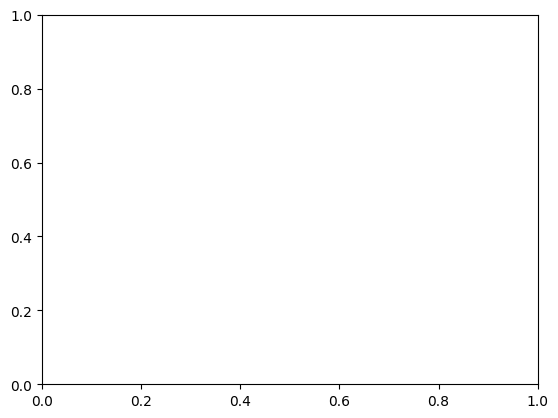

In [44]:
# Save embeddings

dataset_tensor = torch.tensor(dataset.edges_list).to(device)
poincare_embeddings = model.embed(dataset_tensor).cpu().detach().tensor.numpy()

plt.scatter(
    poincare_embeddings[:, 0],
    poincare_embeddings[:, 1],
    c=[x[1] for x in polblogs["labels"]],
    s=2
)

In [46]:
poincare_embeddings.shape

(19025, 2, 8)